In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skimage.util import montage

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from dataset import NibabelDataset

from dynamic_network_architectures.architectures.unet import PlainConvUNet, ResidualEncoderUNet

from batchgenerators.transforms.abstract_transforms import Compose
from batchgenerators.transforms.noise_transforms import GaussianNoiseTransform, GaussianBlurTransform
from batchgenerators.transforms.spatial_transforms import SpatialTransform
from batchgenerators.transforms.resample_transforms import SimulateLowResolutionTransform
from batchgenerators.transforms.color_transforms import BrightnessMultiplicativeTransform, ContrastAugmentationTransform, GammaTransform
from batchgenerators.transforms.utility_transforms import RemoveLabelTransform, RenameTransform, NumpyToTensor

In [2]:
def numpy_collate(batch):
    batch = torch.utils.data._utils.collate.default_collate(batch)
    for k in batch.keys():
        batch[k] = batch[k].numpy()
    return batch

dset = NibabelDataset()
dloader = DataLoader(dset, 3, collate_fn=numpy_collate)

PATCH_SIZE = [128, 128, 128]
NUM_CLASSES = 4

transforms_train = []
# transforms_train.append(SpatialTransform(
#         PATCH_SIZE, patch_center_dist_from_border=None,
#         do_elastic_deform=False, alpha=(0, 0), sigma=(0, 0),
#         do_rotation=False, # do_rotation=True, angle_x=rotation_for_DA['x'], angle_y=rotation_for_DA['y'], angle_z=rotation_for_DA['z'],
#         p_rot_per_axis=1,  # todo experiment with this
#         do_scale=True, scale=(0.7, 1.4),
#         border_mode_data="constant", border_cval_data=0, order_data=3,
#         border_mode_seg="constant", border_cval_seg=-1, order_seg=1,
#         random_crop=False,  # random cropping is part of our dataloaders
#         p_el_per_sample=0, p_scale_per_sample=0.2, p_rot_per_sample=0.2,
#         independent_scale_for_each_axis=False  # todo experiment with this
# ))
transforms_train.append(GaussianNoiseTransform(p_per_sample=0.1))
transforms_train.append(GaussianBlurTransform((0.5, 1.), different_sigma_per_channel=True, p_per_sample=0.2, p_per_channel=0.5))
transforms_train.append(BrightnessMultiplicativeTransform(multiplier_range=(0.75, 1.25), p_per_sample=0.15))
transforms_train.append(ContrastAugmentationTransform(p_per_sample=0.15))
transforms_train.append(SimulateLowResolutionTransform(zoom_range=(0.5, 1), per_channel=True, p_per_channel=0.5, order_downsample=0, order_upsample=3, p_per_sample=0.25, ignore_axes=None))
transforms_train.append(GammaTransform((0.7, 1.5), True, True, retain_stats=True, p_per_sample=0.1))
transforms_train.append(GammaTransform((0.7, 1.5), False, True, retain_stats=True, p_per_sample=0.3))
transforms_train.append(RemoveLabelTransform(-1, 0))
transforms_train.append(RenameTransform('seg', 'target', True))
transforms_train.append(NumpyToTensor(['data', 'target'], 'float'))
transforms_train = Compose(transforms_train)

In [3]:
diter = iter(dloader)
ditem = next(diter)
data = transforms_train(**ditem)
print(data["data"].shape, data["target"].shape)

torch.Size([3, 4, 155, 240, 240]) torch.Size([3, 1, 155, 240, 240])


<Figure size 640x480 with 0 Axes>

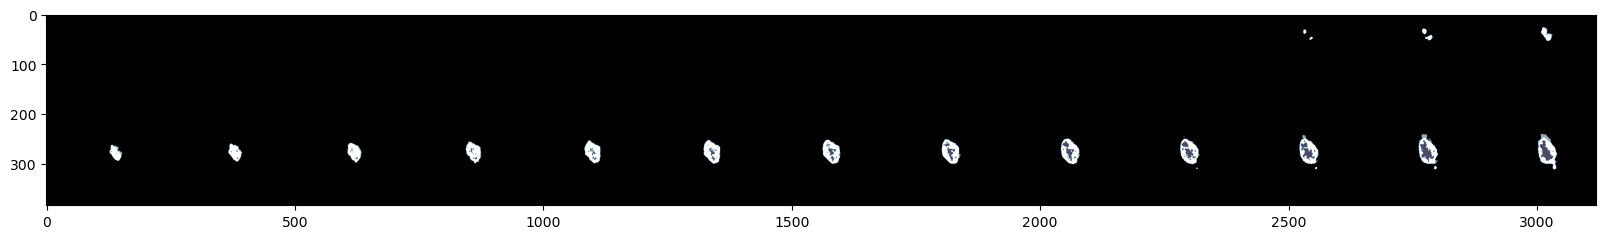

<Figure size 640x480 with 0 Axes>

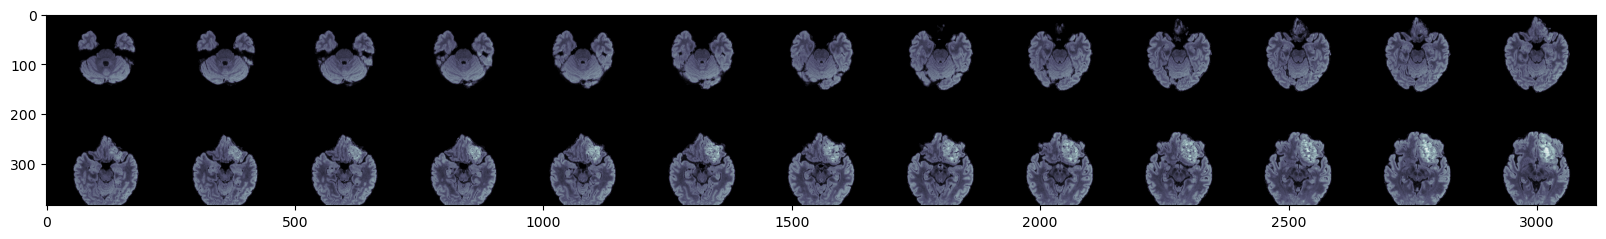

<Figure size 640x480 with 0 Axes>

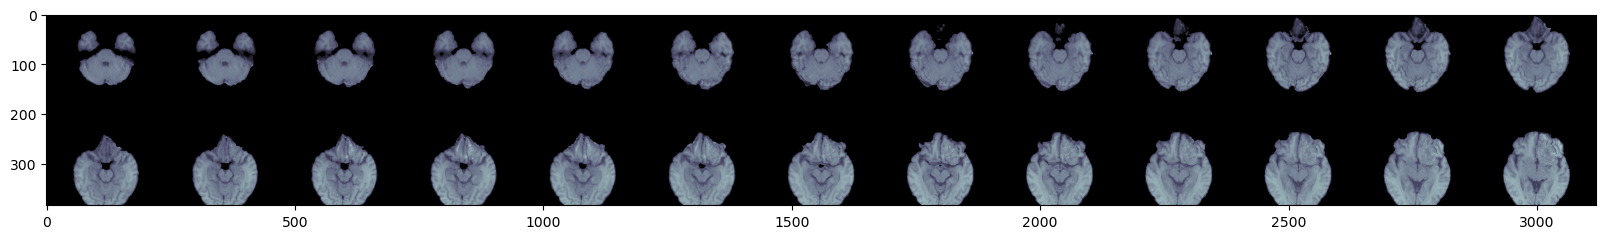

<Figure size 640x480 with 0 Axes>

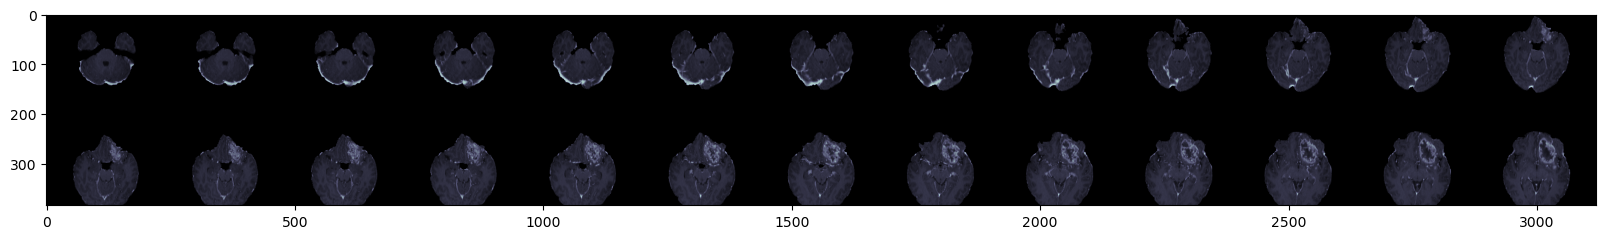

<Figure size 640x480 with 0 Axes>

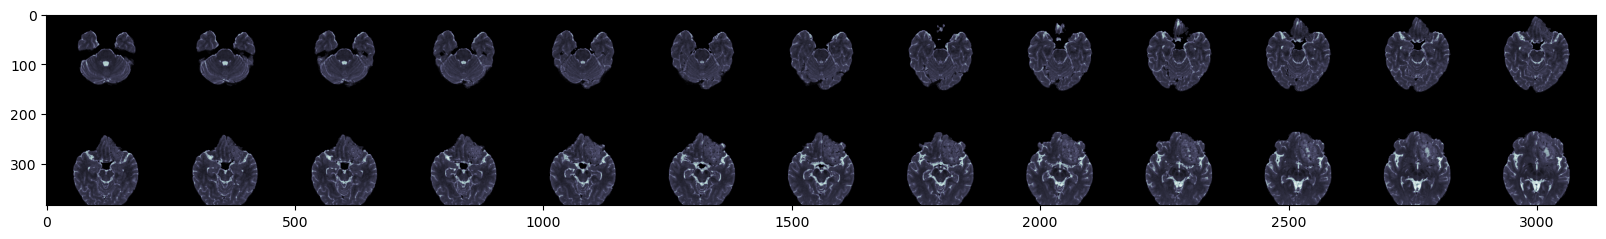

In [4]:
imgs, lbls = data["data"].numpy(), data["target"].numpy()
plt.figure()
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(lbls[0, 0])[768:1152, :], cmap='bone')
plt.show()
plt.figure()
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(imgs[0, 0])[768:1152, :], cmap='bone')
plt.show()
plt.figure()
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(imgs[0, 1])[768:1152, :], cmap='bone')
plt.show()
plt.figure()
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(imgs[0, 2])[768:1152, :], cmap='bone')
plt.show()
plt.figure()
fig, ax1 = plt.subplots(1, 1, figsize=(20, 20))
ax1.imshow(montage(imgs[0, 3])[768:1152, :], cmap='bone')
plt.show()

In [5]:
model = PlainConvUNet(NUM_CLASSES, 6, (32, 64, 125, 256, 320, 320), nn.Conv3d, 3, (1, 2, 2, 2, 2, 2), (2, 2, 2, 2, 2, 2), 4, (2, 2, 2, 2, 2), False, nn.BatchNorm3d, None, None, None, nn.ReLU, deep_supervision=False)

In [6]:
import torch.nn.functional as F
def nearest_multiple_of_32(x):
    remainder = x % 32
    if remainder < 16:
        return x - remainder
    else:
        return x + (32 - remainder)
    
imgs_test = data["data"]
lbls_test = data["target"]
print(imgs_test.shape, lbls_test.shape)
n, m, d, h, w = imgs_test.shape
d_new, h_new, w_new = nearest_multiple_of_32(d), nearest_multiple_of_32(h), nearest_multiple_of_32(w)
imgs_test_interpolated = F.interpolate(imgs_test, size=(d_new, h_new, w_new), mode='trilinear', align_corners=False)
preds_test = model(imgs_test_interpolated)
preds_test_interpolated = F.interpolate(preds_test, size=(d, h, w), mode='trilinear', align_corners=False)
print(preds_test.shape, preds_test_interpolated.shape)
print(lbls_test.unique())

torch.Size([3, 4, 155, 240, 240]) torch.Size([3, 1, 155, 240, 240])
torch.Size([3, 4, 160, 256, 256]) torch.Size([3, 4, 155, 240, 240])
tensor([0., 1., 2., 3.])


In [8]:
from losses import DC_and_CE_loss, MemoryEfficientSoftDiceLoss
soft_dice_kwargs = {
    'batch_dice':True, 
    'smooth': 1e-5, 
    'do_bg': False, 
    'ddp': False
}
ce_kwargs = {}
loss_func = DC_and_CE_loss(soft_dice_kwargs, ce_kwargs, dice_class=MemoryEfficientSoftDiceLoss)

In [10]:
loss = loss_func(preds_test_interpolated, lbls_test)
print(loss)

tensor(1.2395, grad_fn=<AddBackward0>)


In [11]:
from losses import get_tp_fp_fn_tn
output_seg = preds_test_interpolated.argmax(1)[:, None]
preds_onehot_test = torch.zeros(preds_test_interpolated.shape, device=preds_test_interpolated.device, dtype=torch.float32)
preds_onehot_test.scatter_(1, output_seg, 1)
tp, fp, fn, tn = get_tp_fp_fn_tn(preds_onehot_test, lbls_test)
tp_hard = tp.detach().cpu().numpy()
fp_hard = fp.detach().cpu().numpy()
fn_hard = fn.detach().cpu().numpy()
print(preds_onehot_test.shape, lbls_test.shape)
print(tp.shape, fp.shape, fn.shape)

torch.Size([3, 4, 155, 240, 240]) torch.Size([3, 1, 155, 240, 240])
torch.Size([3, 4]) torch.Size([3, 4]) torch.Size([3, 4])


In [12]:
outputs = [{'tp_hard': tp_hard, 'fp_hard': fp_hard, 'fn_hard': fn_hard}, {'tp_hard': tp_hard, 'fp_hard': fp_hard, 'fn_hard': fn_hard}]
from typing import List
def collate_outputs(outputs: List[dict]):
    """
    used to collate default train_step and validation_step outputs. If you want something different then you gotta
    extend this
    we expect outputs to be a list of dictionaries where each of the dict has the same set of keys
    """
    collated = {}
    for k in outputs[0].keys():
        if np.isscalar(outputs[0][k]):
            collated[k] = [o[k] for o in outputs]
        elif isinstance(outputs[0][k], np.ndarray):
            collated[k] = np.vstack([o[k][None] for o in outputs])
        elif isinstance(outputs[0][k], list):
            collated[k] = [item for o in outputs for item in o[k]]
        else:
            raise ValueError(f'Cannot collate input of type {type(outputs[0][k])}. '
                             f'Modify collate_outputs to add this functionality')
    return collated

collate_outputs = collate_outputs(outputs)
tp_sum = np.sum(collate_outputs['tp_hard'], 0)
fp_sum = np.sum(collate_outputs['fp_hard'], 0)
fn_sum = np.sum(collate_outputs['fn_hard'], 0)
print('tp', tp_sum.shape)
print('fp', fp_sum.shape)
print('fn', fn_sum.shape)
global_dc_per_class = [i for i in [2 * i / (2 * i + j + k) for i, j, k in zip(tp_sum, fp_sum, fn_sum)]]
mean_fg_dice = np.nanmean(global_dc_per_class)
print('mean_fg_dice', mean_fg_dice)
print('dice_per_class_or_region', global_dc_per_class)

tp (3, 4)
fp (3, 4)
fn (3, 4)
mean_fg_dice 0.24472441
dice_per_class_or_region [array([0.9542266 , 0.01562217, 0.00639099, 0.00656582], dtype=float32), array([0.9442263 , 0.01669645, 0.01293473, 0.00479763], dtype=float32), array([0.9468111 , 0.01649072, 0.00676107, 0.00516943], dtype=float32)]


In [13]:
print(collate_outputs['tp_hard'])
print(tp_sum)

[[[8.124102e+06 4.348000e+03 6.250000e+02 2.500000e+02]
  [7.886138e+06 6.074000e+03 2.217000e+03 1.960000e+02]
  [7.994117e+06 5.436000e+03 8.110000e+02 1.820000e+02]]

 [[8.124102e+06 4.348000e+03 6.250000e+02 2.500000e+02]
  [7.886138e+06 6.074000e+03 2.217000e+03 1.960000e+02]
  [7.994117e+06 5.436000e+03 8.110000e+02 1.820000e+02]]]
[[1.6248204e+07 8.6960000e+03 1.2500000e+03 5.0000000e+02]
 [1.5772276e+07 1.2148000e+04 4.4340000e+03 3.9200000e+02]
 [1.5988234e+07 1.0872000e+04 1.6220000e+03 3.6400000e+02]]
